In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Notes:**
The EDA part demonstrates basic functions to display images and their color histograms. You can expand this with more sophisticated analyses as per your dataset.

For preprocessing, a custom normalization function scales pixel values. If using transfer learning, you should replace it with the specific preprocess_input function from the model you're using (like VGG16, ResNet, etc.).

The pixel equalization function is provided for grayscale images. For color images, you'd need to modify it as per earlier discussions.

The ImageDataGenerator is set up with basic augmentations. Note that augmentations like RandomZoom and RandomCrop can drastically alter the image, so they should be used with caution.

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Some libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

input_file = np.load('/content/drive/My Drive/public_data.npz', allow_pickle=True)
data = input_file['data']

labels = input_file['labels']

label_dict = {'healthy': 0, 'unhealthy': 1}
labels = np.array([label_dict[label] for label in labels])


2.14.0


# **Display 10 healthy and 10 unhealthy images to try to visually spot apparent distinctions.**

In [ ]:
import matplotlib.pyplot as plt

def show_images(images, labels, num_images=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i]/255.0)
        plt.xlabel('Healthy' if labels[i] == 0 else 'Unhealthy')
    plt.show()

# Filter out 10 healthy and 10 unhealthy images
healthy_images = data[binary_labels == 0][:10]
unhealthy_images = data[binary_labels == 1][:10]

# Display healthy images
print("Healthy Plant Images:")
show_images(healthy_images, [0]*10)

# Display unhealthy images
print("Unhealthy Plant Images:")
show_images(unhealthy_images, [1]*10)

# **Analysis of images with the help of histograms**

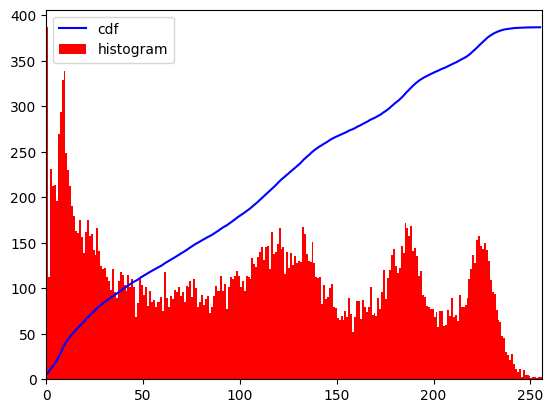

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = data[0]
assert img is not None, "file could not be read, check with os.path.exists()"
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [4]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

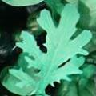

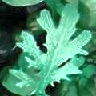

In [14]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

img = data[0]  # For example, the first image in your dataset

# Check if the image is in the correct format
assert img.shape == (96, 96, 3), "The image does not have the expected shape."

# Convert the image from RGB to YUV
img_YUV = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# Equalize the histogram of the Y (luminance) channel
img_YUV[:,:,0] = cv2.equalizeHist(img_YUV[:, :, 0].astype(np.uint8))

# Convert back to RGB
equalized_img = cv2.cvtColor(img_YUV, cv2.COLOR_YUV2RGB)

# Display the images (for comparison)
cv2_imshow(img)
cv2_imshow(equalized_img)




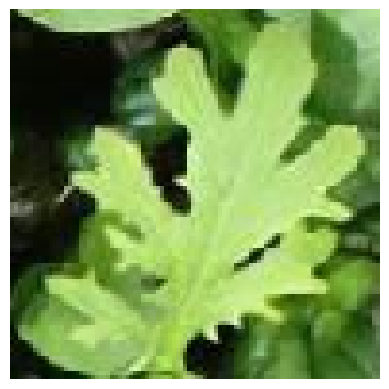

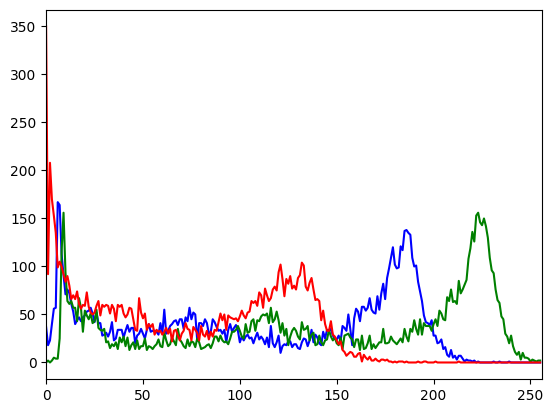

In [21]:
import cv2
import matplotlib.pyplot as plt

# Function to display image using OpenCV
def display_image(image):
    plt.imshow(image/255)
    plt.axis('off')
    plt.show()

# Function to display histogram
def plot_histogram(image):
    for i, col in enumerate(['b', 'g', 'r']):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
        plt.xlim([0, 256])
    plt.show()

# Example usage
img = data[0]   # Load an image
display_image(img)
plot_histogram(img)

# Data Preprocessing for Neural Networks

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Custom normalization for custom models
def custom_normalize(image):
    return image / 255.0

# Transfer Learning: Using preprocess_input from a specific model
# from tensorflow.keras.applications.vgg16 import preprocess_input

# Pixel equalization (assuming grayscale image)
def equalize_image(image):
    return cv2.equalizeHist(image)

# Data augmentation setup
datagen = ImageDataGenerator(
    preprocessing_function=custom_normalize,  # Replace with preprocess_input for transfer learning
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    # Additional augmentations
    brightness_range=[0.8,1.2],  # RandomBrightness
    zoom_range=0.2,             # RandomZoom (use carefully)
    # To add Gaussian noise, you need to write a custom function
)

# Example usage
# datagen.flow_from_directory('path_to_training_data')

#we also use like
preprocessing = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomRotation(0.5),
    tfkl.GaussianNoise(0.5),
    tfkl.RandomContrast(0.5),
    tfkl.RandomBrightness(0.5),
], name='preprocessing')

**Oversampling**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Assuming X_train and y_train are your data and labels
# And minority_class is the label of the minority class

# Find indices of the minority class
#minority_indices = np.where(y_train == minority_class)[0]

# Data generator for augmentation
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Oversample the minority class
'''
for i in minority_indices:
    image = X_train[i].reshape((1,) + X_train[i].shape)  # Reshape to 4D
    for _ in range(10):  # number_of_new_samples is the number of augmented images to generate
        augmented_image = next(data_gen.flow(image, batch_size=1))
        X_train = np.vstack((X_train, augmented_image))
        y_train = np.append(y_train, 1)

'''
